# Data Science Lab: Lab 5 - Nishaanth Joopelli, Daniel Kim, Farzaan Hussain

Submit:
1. A pdf of your notebook with solutions.
2. A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Lab

1. Random Forests
2. Boosting
3. Playing with Ensembling packages, including XGBoost and CatBoost
4. One more time: Revisiting CIFAR-10 and MNIST
5. Getting ready for Kaggle

We will soon open a Kaggle competition made for this class. In that one, you will be participating on your own. This is an intro to get us started, and also an excuse to work with regularization and regression which we have been discussing. You'll revisit some problems from earlier labs, this time using Random Forests, and Boosting. In particular, you should take this opportunity to become familiar with some very useful packages for boosting. I recommend not only the boosting packages in scikit-learn, but also XGBoost, GBM Light, CatBoost and possibly others. You have to download these and get them running, and then read their documentation to figure out how they work, what the hyperparameters are, etc.

Also, the metric we will use in the Kaggle competition is AUC. We will discuss this. In the meantime, you may want to understand how it works. At least one key thing to remember: to get a good AUC score, you need to submit a soft score (probabilities) and not rounded values (i.e., not 0s and 1s).


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from scipy.stats.stats import pearsonr


%matplotlib inline

/tmp/ipykernel_3789472/3722246774.py:11: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


## Problem 1: Revisiting Logistic Regression and MNIST

We have played with the handwriting recognition problem (the MNIST data set) using decision trees. We have also considered the same problem using multi-class Logistic Regression in a previous Lab. We revisit this one more time.

**Part 1**: Use Random Forests to try to get the best possible *test accuracy* on MNIST. This involves getting acquainted with how Random Forests work, understanding their parameters, and therefore using Cross Validation to find the best settings. How well can you do? You should use the accuracy metric, since this is what you used in the previous Lab  -- therefore this will allow you to compare your results from Random Forests with your results from L1- and L2- Regularized Logistic Regression.

What are the hyperparameters of your best model?

**Part 2**: Use Boosting to do the same. Take the time to understand how XGBoost works (and/or other boosting packages available -- CatBoost is also another favorite). Try your best to tune your hyper-parameters. As added motivation: typically the winners and near-winners of the Kaggle competition are those that are best able to tune and cross validate XGBoost. What are the hyperparameters of your best model?


## Problem 2: Revisiting Logistic Regression and CIFAR-10

Now that you have your pipeline set up, it should be easy to apply the above procedure to CIFAR-10. If you did something that takes significant computation time, keep in mind that CIFAR-10 is a few times larger.

**Part 1**: What is the best accuracy you can get on the test data, by tuning Random Forests? What are the hyperparameters of your best model?

**Part 2**: What is the best accuracy you can get on the test data, by tuning XGBoost? What are the hyperparameters of your best model?

## Problem 3: Revisiting Kaggle

This is a continuation of Problem 2 from Lab 3. You already did some first steps there, including making a Kaggle account, and trying ridge and lasso linear regression. You also tried stacking.

**Part 1** (Nothing to hand in) Revisit Lab 3 and your answers there.

**Part 2**: Train a gradient boosting regression, e.g., using XGBoost. What score can you get just from a single XGB? (you will need to optimize over its parameters).

**Part 3**: Do your best to get a more accurate model. Try feature engineering and stacking many models. You are allowed to use any public tool in python. No non-python tools allowed. State what hyperparameters and models you tried, and the corresponding train/test error.

**Part 4**: (Optional)  Read the Kaggle forums, tutorials and Kernels in this competition. This is an excellent way to learn. Include in your report if you find something in the forums you like, or if you made your own post or code post, especially if other Kagglers liked or used it afterwards.

**Other**: Be sure to read and learn the rules of Kaggle! No sharing of code or data outside the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with your Lab partner. This is more important for live competitions of course.

In the real in-class Kaggle competition (which will be next), you will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report, due after the competition closes, you will explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. You can start thinking about this now.

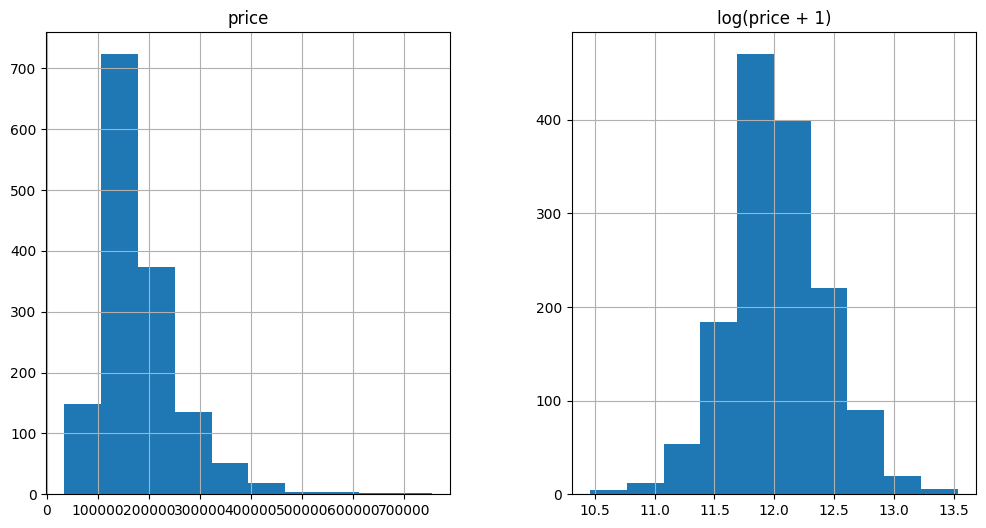

In [2]:

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

#Split into train and test data
X_tr, X_test, y_tr, y_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

**Part 2**


In [42]:
# Part 2
from sklearn.metrics import mean_squared_error, r2_score



from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for hyperparameters
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV since GridSearch takes longer
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_tr, y_tr)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Best estimator
best_xgb = random_search.best_estimator_

# Predict on validation set
y_train_pred_best = best_xgb.predict(X_tr)
y_test_pred_best = best_xgb.predict(X_test)

# Evaluate the optimized model
training_error = mean_squared_error(y_tr, y_train_pred_best)
test_error = mean_squared_error(y_test, y_test_pred_best)

print(f"XGBoost Training Error: {training_error:.4f}")
print(f"XGBoost Test Error: {test_error:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters found:  {'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
XGBoost Training Error: 0.0001
XGBoost Test Error: 0.0175


**Part 3**

In [22]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import skew

# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Combine train and test data for preprocessing
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

# Log-transform the target
train["SalePrice"] = np.log1p(train["SalePrice"])

# Log-transform skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# One-hot encoding
all_data = pd.get_dummies(all_data)

# Fill missing values
all_data = all_data.fillna(all_data.mean())

# Split back into training and test sets
X_full_train = all_data[:train.shape[0]]  
X_full_test = all_data[train.shape[0]:]  
y = train.SalePrice                       

# Split X_full_train and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full_train, y, test_size=0.2, random_state=42)

# Feature Engineering Steps
# Identify numerical features for interaction terms
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Select top 10 numerical features based on variance
top_numerical = X_train[numerical_features].var().sort_values(ascending=False).head(10).index.tolist()

# Function to create interaction terms used for both train and test data
def create_interaction_terms(df, top_features):
    interaction_terms = pd.DataFrame(index=df.index)
    for pair in combinations(top_features, 2):
        new_feature = f"{pair[0]}_x_{pair[1]}"
        interaction_terms[new_feature] = df[pair[0]] * df[pair[1]]
    return interaction_terms

# Create interaction terms for training and testing data
interaction_terms_train = create_interaction_terms(X_train, top_numerical)
interaction_terms_test = create_interaction_terms(X_test, top_numerical)

# Concatenate interaction terms back to the original data
X_train = pd.concat([X_train, interaction_terms_train], axis=1)
X_test = pd.concat([X_test, interaction_terms_test], axis=1)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Fit and transform on training data
X_train_poly = poly.fit_transform(X_train)

# Transform testing data
X_test_poly = poly.transform(X_test)

# Get feature names for new DataFrame
poly_features = poly.get_feature_names_out(X_train.columns)

# Convert to DataFrame
X_train_poly = pd.DataFrame(X_train_poly, columns=poly_features, index=X_train.index)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly_features, index=X_test.index)

# Align columns of test data to training data
X_test_poly = X_test_poly.reindex(columns=X_train_poly.columns, fill_value=0)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train_poly)
X_test = imputer.transform(X_test_poly)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=200)
selector.fit(X_train, y_train)

# Transform the data
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

# Get selected feature names
selected_features = np.array(poly_features)[selector.get_support()]

# Optionally, convert to DataFrame (if you need feature names)
X_train = pd.DataFrame(X_train, columns=selected_features)
X_test = pd.DataFrame(X_test, columns=selected_features)

# Convert targets to numpy arrays (if not already)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Check shapes to ensure consistency
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1168, 200)
X_test shape: (292, 200)
y_train shape: (1168,)
y_test shape: (292,)


In [23]:
# Creating all models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# All the models I'm going to use
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
gbr_reg = GradientBoostingRegressor(random_state=42)

models = {
    'XGBoost': xgb_reg,
    'RandomForest': rf_reg,
    'GradientBoosting': gbr_reg,
}

# Hyperparameter Tuning (used randomized hyperparameters within reasonable range)
param_grids = {
    'XGBoost': {
        'n_estimators': stats.randint(100, 1000),
        'max_depth': stats.randint(3, 15),
        'learning_rate': stats.uniform(0.01, 0.3),
        'subsample': stats.uniform(0.5, 0.5),
        'colsample_bytree': stats.uniform(0.5, 0.5),
        'gamma': stats.uniform(0, 0.5),
        'min_child_weight': stats.randint(1, 10),
        'alpha': stats.uniform(0, 1),  # L1 regularization (Lasso)
        'lambda': stats.uniform(0, 1),  # L2 regularization (Ridge)
    },
    'RandomForest': {
        'n_estimators': stats.randint(100, 1000),
        'max_depth': [None] + list(range(5, 30)),
        'min_samples_split': stats.randint(2, 20),
        'min_samples_leaf': stats.randint(1, 20),
        'bootstrap': [True, False]
    },
    'GradientBoosting': {
        'n_estimators': stats.randint(100, 1000),
        'learning_rate': stats.uniform(0.01, 0.3),
        'max_depth': stats.randint(3, 15),
        'subsample': stats.uniform(0.5, 0.5),
        'min_samples_split': stats.randint(2, 20),
        'alpha': stats.uniform(0, 1),  # Adding L2 regularization to GradientBoosting
    }
}

best_models = {}
model_performances = {}
hyperparameter_results = {}
n_iter_search = 50  

# Function to format parameters as floating points and not np.float
def format_params(params):
    formatted_params = {}
    for key, value in params.items():
        if isinstance(value, (float, np.float64, np.float32)):
            formatted_params[key] = f"{value:.4f}"
        else:
            formatted_params[key] = value
    return formatted_params

# Finds best hyperparameters for each model
for model_name in models:
    # For tracking when each model is being hyperparameter tuned
    print(f"Hyperparameter tuning for {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    # Initialize RandomizedSearchCV since GridSearch takes longer
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        return_train_score=True #Needed to display all the hyperparameters used
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Store the best model
    best_models[model_name] = random_search.best_estimator_

    # Store hyperparameter results for reference for part 3
    results_df = pd.DataFrame(random_search.cv_results_)
    hyperparameter_results[model_name] = results_df
    
    # Predict on training and test sets
    y_train_pred = random_search.predict(X_train)
    y_test_pred = random_search.predict(X_test)
    
    # Calculate testing and training error
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    # Store performances for reference for part 3
    model_performances[model_name] = {
        'Best Parameters': random_search.best_params_,
        'Training Error': train_error,
        'Testing Error': test_error
    }
    
    # Print the corresponding training error and test error for the best parameters for each model
    print(f"{model_name} - Train Error: {train_error:.4f}, Test Error: {test_error:.4f}\n, Best_Parameter: {format_params(random_search.best_params_)}\n")

# Stacking
stacking_models = [
    ('xgb', best_models['XGBoost']),
    ('rf', best_models['RandomForest']),
    ('gbr', best_models['GradientBoosting']),
]

# Initialize Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=stacking_models,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train Stacking Regressor
stacking_reg.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred_stack = stacking_reg.predict(X_train)
y_test_pred_stack = stacking_reg.predict(X_test)

# Calculate testing and training error
train_error = mean_squared_error(y_train_pred_stack, y_train_pred_stack)
test_error = mean_squared_error(y_test, y_test_pred_stack)

# Loop over the selected models
for model_name in list(models.keys()):
    results_df = hyperparameter_results[model_name]
    
    # Select parameter columns and corresponding test and train error
    columns_to_display = [
        'mean_test_score', 'std_test_score', 'mean_train_score'
    ] + [col for col in results_df.columns if col.startswith('param_')]
    
    # Round scores for models (these a)
    results_df[['mean_test_score', 'std_test_score', 'mean_train_score']] = results_df[['mean_test_score', 'std_test_score', 'mean_train_score']].round(4)
    
    # Display all hyperparameters tried for the model
    print(f"All hyperparameters tried for {model_name}:")
    print(results_df[columns_to_display])
    print("\n" + "="*80 + "\n")

print(f"Training Error: {train_error:.8f}")
print(f"Testing Error: {test_error:.4f}\n")

Hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


XGBoost - Train Error: 0.0074, Test Error: 0.0218
, Best_Parameter: {'alpha': '0.1958', 'colsample_bytree': '0.5347', 'gamma': '0.0504', 'lambda': '0.0182', 'learning_rate': '0.0383', 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 948, 'subsample': '0.8279'}

Hyperparameter tuning for RandomForest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
RandomForest - Train Error: 0.0044, Test Error: 0.0230
, Best_Parameter: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 319}

Hyperparameter tuning for GradientBoosting...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
GradientBoosting - Train Error: 0.0051, Test Error: 0.0219
, Best_Parameter: {'alpha': '0.2848', 'learning_rate': '0.0211', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 741, 'subsample': '0.7055'}

All hyperparameters tried for XGBoost:
    mean_test_score  std_test_score  mean_train_score  param_alpha  \
0           -0.0224    